In [40]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_classification import BaseVQVAE
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

%matplotlib widget

Interesting datasets to look at:
1. CBF
2. Symbols
3. GunPointOldVersusYoung
4. Swedishleaf

do: pip3 install ipympl to view the 3d plots interactively

Define which dataset to analyse here:

In [111]:
dataset_analysis = 'CBF'

Loading vqvae and data

In [112]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

config['dataset']['dataset_name'] = dataset_analysis

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

vqvae = BaseVQVAE(input_length, config)

self.X_train.shape: (30, 128)
self.X_test.shape: (900, 128)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


grabbing zqs

In [113]:
zqs_train, s_train = vqvae.run_through_codebook(train_data_loader)
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test, s_test = vqvae.run_through_codebook(test_data_loader)
y_test = test_data_loader.dataset.Y.flatten().astype(int)
#Umap density based

zqs = np.concatenate((zqs_test, zqs_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

print("zqs_train shape:",zqs_train.shape)
print("zqs_test shape:",zqs_test.shape)
print("zqs shape:",zqs.shape)
print("y shape:", y.shape)

zqs_train shape: (30, 2560)
zqs_test shape: (900, 2560)
zqs shape: (930, 2560)
y shape: (930,)


## UMAP

In [114]:
import umap

dens_mapper_2 = umap.UMAP(densmap=True, n_components=2).fit(zqs)
dens_mapper_3 = umap.UMAP(densmap=True, n_components=3).fit(zqs)

embs_train = umap.UMAP(densmap=True, n_components=2).fit(zqs_train).embedding_
embs_test = umap.UMAP(densmap=True, n_components=2).fit(zqs_test).embedding_

embs_2 = dens_mapper_2.embedding_
embs_3 = dens_mapper_3.embedding_

Text(0.5, 1.0, 'zqs train')

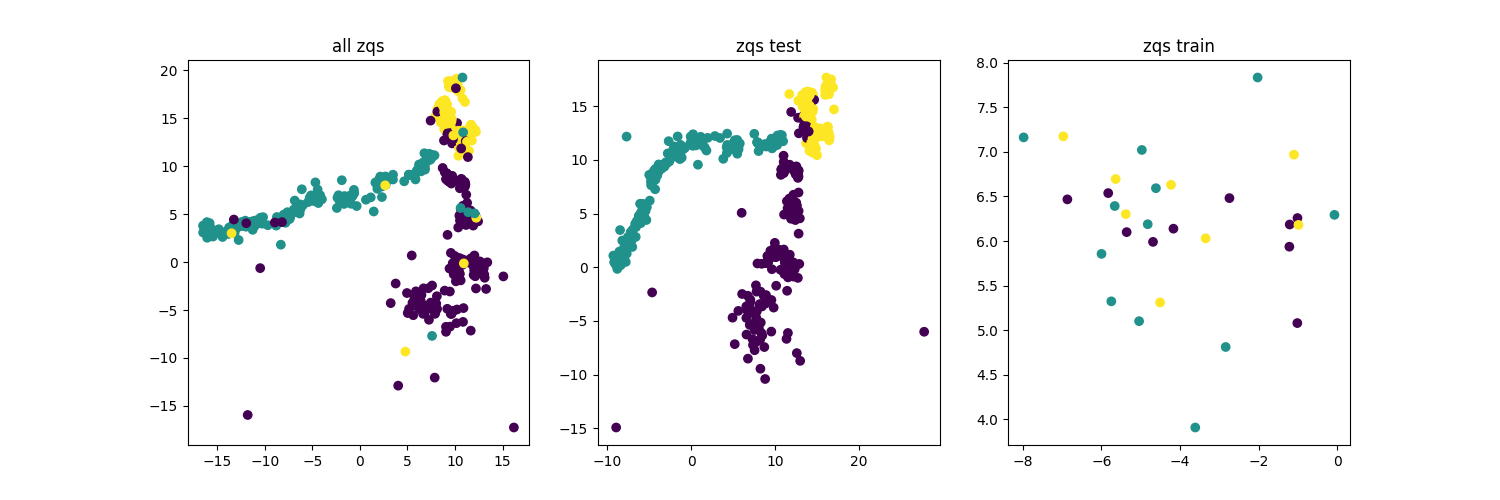

In [67]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(embs_2[:, 0], embs_2[:, 1], c=y); ax[0].set_title("all zqs")
ax[1].scatter(embs_test[:,0], embs_test[:,1], c=y_test); ax[1].set_title("zqs test")
ax[2].scatter(embs_train[:,0], embs_train[:,1], c=y_train); ax[2].set_title("zqs train")

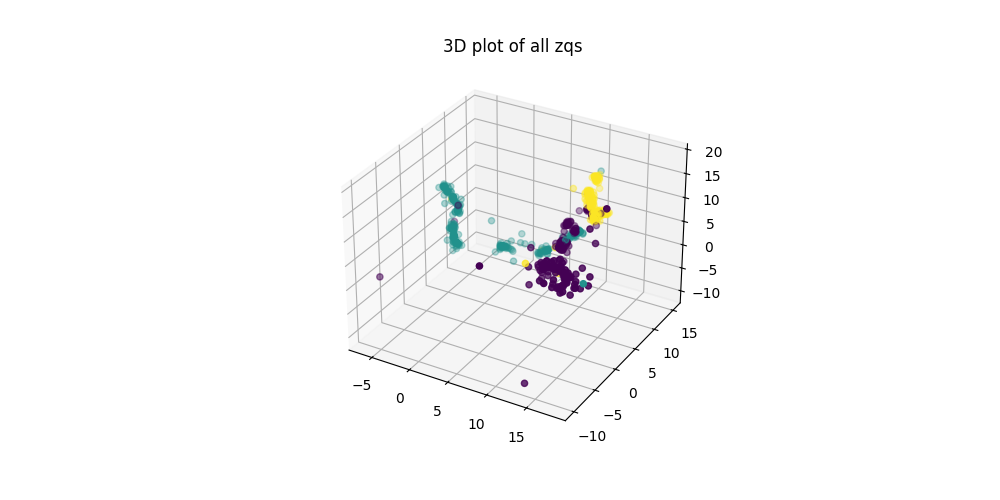

In [76]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embs_3[:, 0], embs_3[:, 1], embs_3[:, 2], c=y)
ax.set_title("3D plot of all zqs")
plt.show()

## T-SNE

In [79]:
from sklearn.manifold import TSNE

zqs_test_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_test)
zqs_train_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs_train)
zqs_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs)
zqs_embedded3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(zqs)

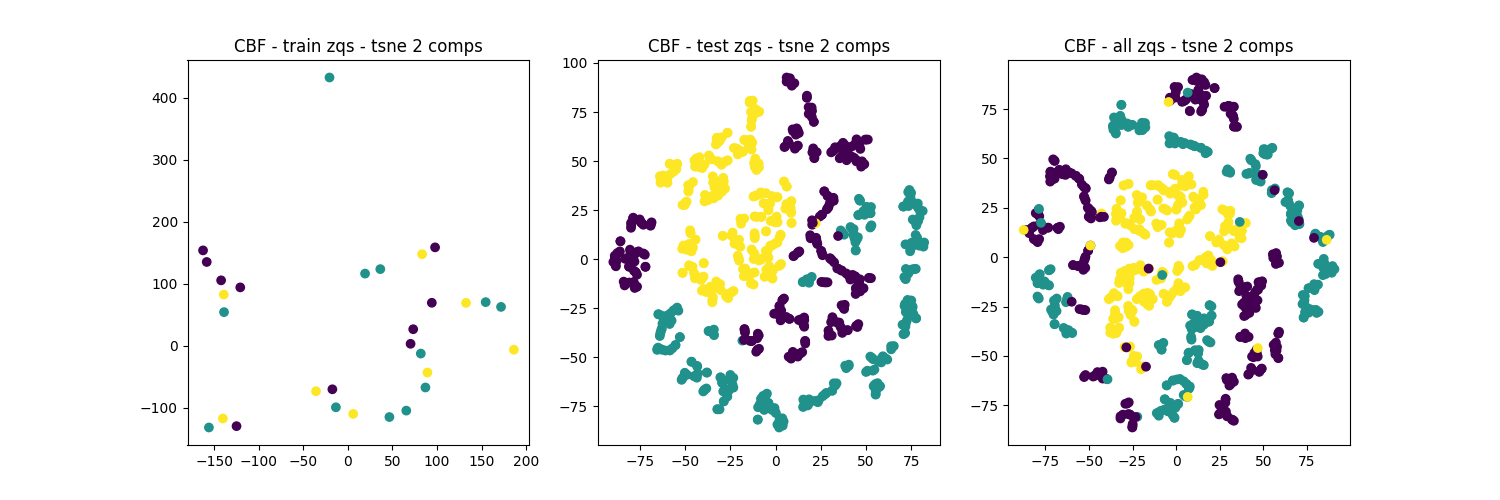

In [82]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(zqs_train_embedded2[:, 0], zqs_train_embedded2[:, 1], c=y_train); ax[0].set_title(f"{config['dataset']['dataset_name']} - train zqs - tsne 2 comps")
ax[1].scatter(zqs_test_embedded2[:, 0], zqs_test_embedded2[:, 1], c=y_test); ax[1].set_title(f"{config['dataset']['dataset_name']} - test zqs - tsne 2 comps")
ax[2].scatter(zqs_embedded2[:,0], zqs_embedded2[:,1], c=y); ax[2].set_title(f"{config['dataset']['dataset_name']} - all zqs - tsne 2 comps")
plt.show()

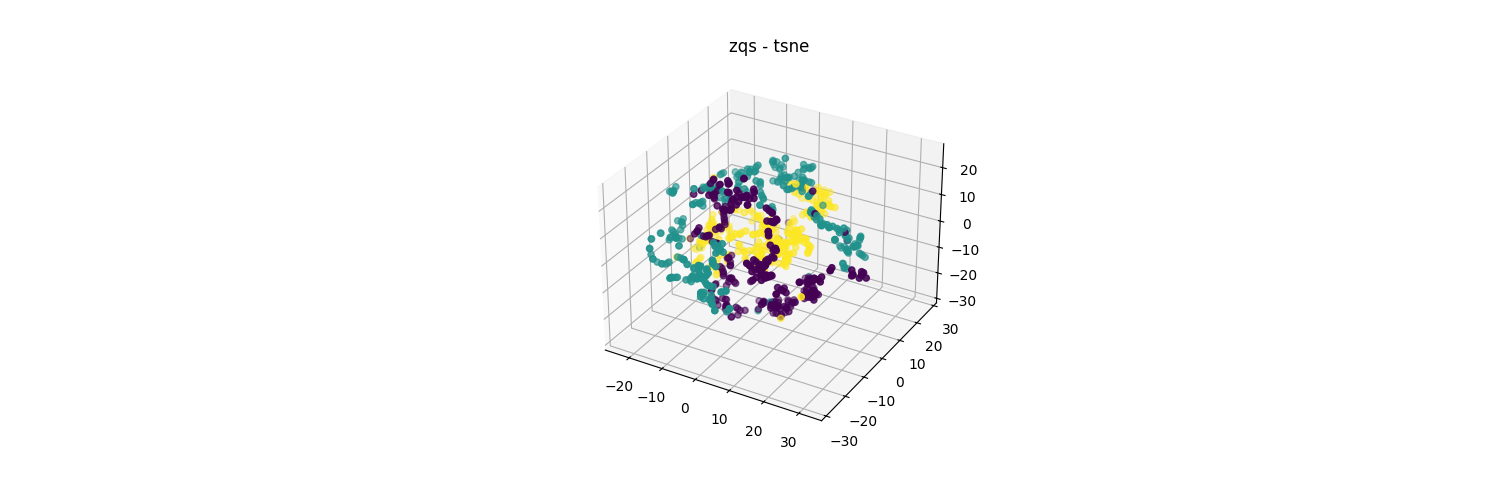

In [84]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_embedded3[:, 0], zqs_embedded3[:, 1], zqs_embedded3[:, 2], c=y)
ax.set_title("zqs - tsne")
plt.show()

## PCA on discrete latent variables zq's


In [85]:
from sklearn.decomposition import PCA

pca2_test = PCA(n_components=2).fit(zqs_test)
pca2_train = PCA(n_components=2).fit(zqs_train)
pca2_all = PCA(n_components=2).fit(zqs)
pca3_all = PCA(n_components=3).fit(zqs)


print("sum variance explained test 2 comps:", sum(pca2_test.explained_variance_ratio_))
print("sum variance explained train 2 comps:", sum(pca2_train.explained_variance_ratio_))
print("sum variance explained all 2 comps:", sum(pca2_all.explained_variance_ratio_))
print("sum variance explained all 2 comps:", sum(pca3_all.explained_variance_ratio_))

sum variance explained test 2 comps: 0.6124933212995529
sum variance explained train 2 comps: 0.6239177286624908
sum variance explained all 2 comps: 0.612219512462616
sum variance explained all 2 comps: 0.6980808228254318


In [93]:
zqs_test_2pc = pca2_test.transform(zqs_test)
zqs_train_2pc = pca2_train.transform(zqs_train)
zqs_all_2pc = pca2_all.transform(zqs)
zqs_all_3pc = pca3_all.transform(zqs)

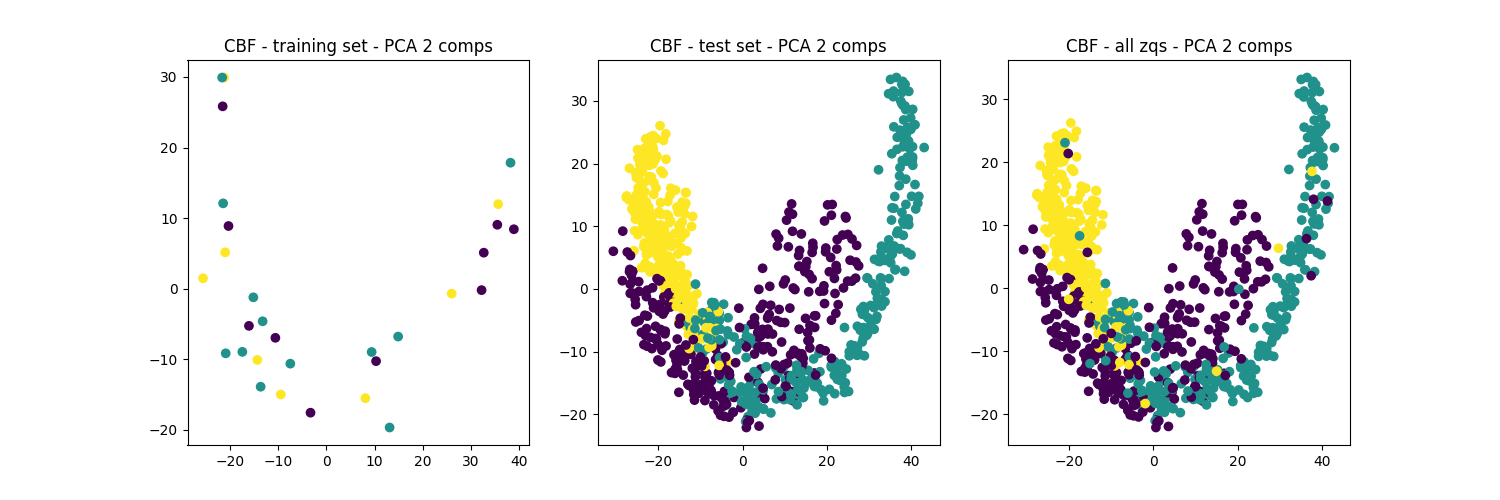

In [94]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(zqs_train_2pc[:, 0], zqs_train_2pc[:, 1], c=y_train); ax[0].set_title(f"{config['dataset']['dataset_name']} - training set - PCA 2 comps")
ax[1].scatter(zqs_test_2pc[:, 0], zqs_test_2pc[:, 1], c=y_test); ax[1].set_title(f"{config['dataset']['dataset_name']} - test set - PCA 2 comps")
ax[2].scatter(zqs_all_2pc[:, 0], zqs_all_2pc[:,1], c=y); ax[2].set_title(f"{config['dataset']['dataset_name']} - all zqs - PCA 2 comps")
plt.show()

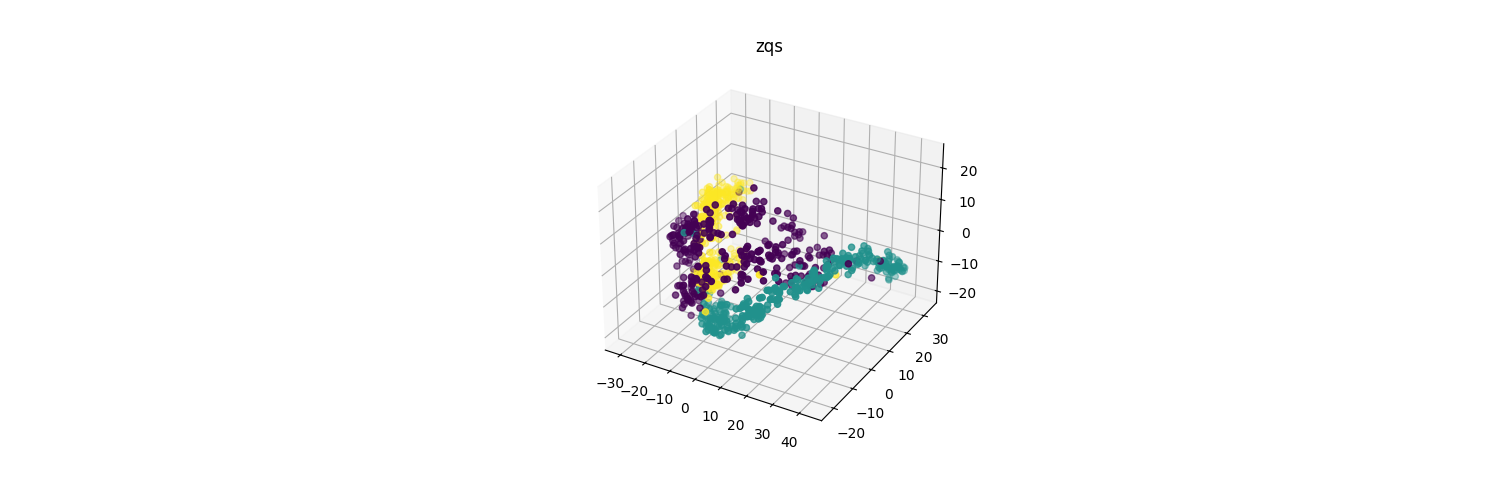

In [96]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zqs_all_3pc[:, 0], zqs_all_3pc[:, 1], zqs_all_3pc[:, 2], c=y)
ax.set_title("zqs")
plt.show()

## Codebook analysis

In [105]:
codebook = vqvae.get_codebook()

pca_codebook_3 = PCA(n_components=3).fit_transform(codebook)

pca_codebook_2 = PCA(n_components=2).fit_transform(codebook)

umap_codebook_2 = umap.UMAP(densmap=True, n_components=2).fit_transform(zqs)


Text(0.5, 1.0, 'codebook PCA transformed')

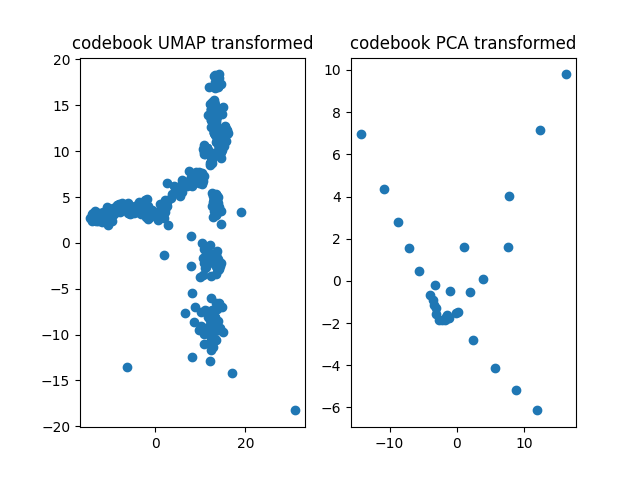

In [110]:
f, ax = plt.subplots(1, 2)
ax[0].scatter(umap_codebook_2[:, 0], umap_codebook_2[:, 1]); ax[0].set_title("codebook UMAP transformed")
ax[1].scatter(pca_codebook_2[:, 0], pca_codebook_2[:, 1]); ax[1].set_title("codebook PCA transformed")